In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from catboost import CatBoostRegressor, FeaturesData, Pool
import re

In [2]:
train = pd.read_csv('../input_data/rank_train.csv')
test = pd.read_csv('../input_data/rank_test.csv')

player = pd.read_csv('../input_data/player_prefecture.csv', header=None)
fifa_2014_mem = pd.read_csv('../input_data/fifa2014mem.csv')

In [3]:
# 無観客試合を削除
train = train[train['id'] != 15699].copy()

In [4]:
# 各スタジアムのcapaに対する動員比率
pre_y_capa = pd.DataFrame(train.groupby('stadium').sum()['y'] / train.groupby('stadium').sum()['capa'])
y_capa_df = pd.DataFrame({'stadium':np.array(pre_y_capa.index), 'y_capa':np.array(pre_y_capa[0])})

train = pd.merge(train, y_capa_df, how = 'left', on = 'stadium')
test = pd.merge(test, y_capa_df, how = 'left', on = 'stadium')

In [5]:
train_x = train.copy().drop(['y', 'id'], axis=1)
train_y = train['y']
test_x = test.drop(['id'], axis=1)

In [6]:
all_x = pd.concat([train_x, test_x])
all_x

,year,stage,match,gameday,time,home,away,stadium,tv,home_score,...,away_08,away_09,away_10,away_11,name,address,capa,team,rank,y_capa
0,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合,1,...,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694,ベガルタ仙台,1,0.777358
1,2012,Ｊ１,第３節第１日,03/24(土),13:03,ベガルタ仙台,大宮アルディージャ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）,4,...,渡邉 大剛,曺 永哲,東 慶悟,ラファエル,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694,ベガルタ仙台,1,0.777358
2,2012,Ｊ１,第５節第１日,04/07(土),14:03,ベガルタ仙台,ジュビロ磐田,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ仙台／ＮＨＫ静岡,2,...,山田 大記,松浦 拓弥,菅沼 実,前田 遼一,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694,ベガルタ仙台,1,0.777358
3,2012,Ｊ１,第７節第１日,04/21(土),19:04,ベガルタ仙台,ＦＣ東京,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ ＢＳ１,4,...,石川 直宏,大竹 洋平,羽生 直剛,渡邉 千真,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694,ベガルタ仙台,1,0.777358
4,2012,Ｊ１,第１０節第１日,05/06(日),13:04,ベガルタ仙台,清水エスパルス,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ仙台,0,...,河井 陽介,ジミー フランサ,大前 元紀,高木 俊幸,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694,ベガルタ仙台,1,0.777358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,2014,Ｊ２,第４２節第１日,11/23(日・祝),14:04,ザスパクサツ群馬,愛媛ＦＣ,正田醤油スタジアム群馬,スカパー！／スカパー！プレミアムサービス,3,...,吉村 圭司,原川 力,堀米 勇輝,河原 和寿,正田醤油スタジアム群馬,群馬県前橋市敷島町66,15135,ザスパクサツ群馬,15,0.228665
309,2014,Ｊ２,第３５節第１日,10/04(土),13:03,Ｖ・ファーレン長崎,ファジアーノ岡山,長崎市総合運動公園かきどまり陸上競技場,スカパー！／スカパー！プレミアムサービス,1,...,三村 真,片山 瑛一,久保 裕一,ウーゴ,長崎市総合運動公園かきどまり陸上競技場,長崎県長崎市柿泊町2210,16000,Ｖ・ファーレン長崎,13,0.246250
310,2014,Ｊ２,第３８節第１日,10/26(日),14:03,Ｖ・ファーレン長崎,ロアッソ熊本,長崎市総合運動公園かきどまり陸上競技場,スカパー！／スカパー！プレミアムサービス,0,...,髙柳 一誠,嶋田 慎太郎,澤田 崇,齊藤 和樹,長崎市総合運動公園かきどまり陸上競技場,長崎県長崎市柿泊町2210,16000,Ｖ・ファーレン長崎,10,0.246250
311,2014,Ｊ２,第３６節第１日,10/11(土),13:03,コンサドーレ札幌,ジェフユナイテッド千葉,札幌厚別公園競技場,スカパー！／スカパー！プレミアムサービス,0,...,幸野 志有人,町田 也真人,谷澤 達也,森本 貴幸,札幌厚別公園競技場,北海道札幌市厚別区上野幌3条1-2-1,19620,コンサドーレ札幌,8,0.368511


In [7]:
# rank関数
def rank(base_col, col_name, rank_arr):
    rank = 0
    all_x[col_name] = 0
    for i in rank_arr:
        all_x.loc[all_x[base_col]==i, col_name] = rank
        rank += 1
    return all_x

In [8]:
# 試合会場の都道府県の25歳以上の100人当たりのサッカー人口
address_col_num = all_x.columns.get_loc('address')
all_x['player_pref'] = 0
for i in range(len(player)):
    for j in range(len(all_x)):
        if player.iloc[i, 1] in all_x.iloc[j, address_col_num]:
            all_x.iloc[j, -1] = player.iloc[i, 3]
            
home_0_col_num = all_x.columns.get_loc('home_01')
away_11_col_num = all_x.columns.get_loc('away_11')

# 各試合のFIFA2014日本代表選手の出場選手人数
all_x['fifa_men_sum'] = 0
for i in range(len(fifa_2014_mem)):
    for mem in range(home_0_col_num, away_11_col_num + 1):
        for j in range(len(all_x)):
            if fifa_2014_mem.iloc[i, 0] == all_x.iloc[j, mem]:
                all_x.iloc[j, -1] += 1

In [9]:
all_x['week'] = all_x['gameday'].str[-2].replace(('月','火','水','木','金'), '平日')
all_x['iweek'] = 0
all_x.loc[all_x['week']=='土', 'iweek'] = 3
all_x.loc[all_x['week']=='日', 'iweek'] = 1
all_x.loc[all_x['week']=='祝', 'iweek'] = 2

all_x['match_day'] =all_x['match'].str.split('第', expand = True)[2].str.split('日',expand=True)[0].astype('int')
all_x['match'] =all_x['match'].str.split('第', expand = True)[1].str.split('節',expand=True)[0].astype('int')


all_x['gameday'] = all_x['gameday'].str.split('/', expand = True)[0].astype('int')

all_x['h_time'] = all_x['time'].str.split(':', expand = True)[0].astype('int')
all_x['m_time'] = all_x['time'].str.split(':', expand = True)[1].astype('int')

all_x['capa_fifa'] = all_x['capa'] * all_x['fifa_men_sum']
all_x['capa_iweek'] = all_x['capa'] * all_x['iweek']

all_x['t_time'] = all_x.apply(lambda x: x['h_time'] * 60 + x['m_time'], axis=1)
all_x['pre_rank_t_time'] = np.floor(all_x['t_time'] /50) * 50
all_x['t_time'] = all_x['t_time'].max() - np.clip(all_x['t_time'], 782, 1144)
t_time_rank_arr = [1200.0, 750.0, 1050.0, 1150.0, 950.0, 1100.0, 1000.0, 800.0, 900.0, 850.0]
all_x = rank(base_col='pre_rank_t_time', col_name='t_time_rank', rank_arr=t_time_rank_arr)

# rank関数を用いた特徴量
time_rank_arr = [20, 12, 17, 15, 18, 13, 16, 14, 19]
all_x = rank(base_col='h_time', col_name='h_time_rank', rank_arr=time_rank_arr)

gameday_rank_arr = [12, 6, 10, 11, 9, 8, 7, 4, 3, 5]
all_x = rank(base_col='gameday', col_name='gameday_rank',  rank_arr=gameday_rank_arr)

pref_rank_arr =[2.38, 2.58, 2.68, 2.87, 1.68, 2.11, 2.13, 2.79,  2.0, 2.24, 2.91,
              2.82, 2.94,  3.4, 3.29, 2.52, 2.55, 2.67, 3.55, 3.91, 2.73, 3.26,
               4.5, 3.32, 4.35, 2.99, 2.09, 3.96, 3.68, 5.01]
all_x = rank(base_col='player_pref', col_name='pref_rank',  rank_arr=pref_rank_arr)

match_day_rank_arr = [4, 3, 1, 2]
all_x = rank(base_col='match_day', col_name='match_day_rank',  rank_arr=match_day_rank_arr)

y_capa_y_mean = train.groupby('y_capa')['y'].mean()
all_x = rank(base_col='y_capa', col_name='y_capa_rank',  rank_arr=y_capa_y_mean.sort_values().index)

referee_y_mean = train.groupby('referee')['y'].mean()
all_x = rank(base_col='referee', col_name='referee_rank',  rank_arr=referee_y_mean.sort_values().index)

all_x['j2_capa'] = all_x.apply(lambda x: x['capa'] * 0.8 if x['stage'] == 'Ｊ２' else x['capa'], axis=1)
all_x['j2_capa'] = all_x['j2_capa'] **0.5

all_x['rank'] = all_x['rank'].max() - all_x['rank']

# tvに関する特徴量
all_x['nhk_sogo'] = all_x.apply(lambda x: 1 if '総合' in x['tv'] else 0, axis=1)
all_x['tv_num'] = all_x.apply(lambda x: len(x['tv'].split('／')), axis=1)
all_x['record'] = all_x.apply(lambda x: 0 if '録' in x['tv'] else 1, axis=1)

all_x['temperature'] = np.floor(all_x['temperature'])
all_x['temperature'] = all_x.apply(lambda x:all_x['temperature'].max() - x['temperature'] if all_x['temperature'].median() < x['temperature'] else x['temperature'], axis=1)

In [10]:
all_x = all_x[[
    'j2_capa',
    'rank',
    'stage',
    'weather',
    'stadium',
    'week', 
    'home',
    'away',
    'fifa_men_sum',
    'iweek',
    't_time',
    'pre_rank_t_time',
    't_time_rank',
    'h_time_rank',
    'gameday_rank',
    'pref_rank',
    'match_day_rank',
    'nhk_sogo',
    'tv_num',
    'record',
    'temperature',
    'match',
    'referee_rank',
    'y_capa',
    'capa_fifa',
    'capa_iweek',
]]
cat_cols = all_x.select_dtypes(include=object).columns

In [11]:
all_x

,j2_capa,rank,stage,weather,stadium,week,home,away,fifa_men_sum,iweek,...,match_day_rank,nhk_sogo,tv_num,record,temperature,match,referee_rank,y_capa,capa_fifa,capa_iweek
0,140.335313,21,Ｊ１,雨,ユアテックスタジアム仙台,土,ベガルタ仙台,鹿島アントラーズ,0,3,...,2,1,4,1,3.0,1,43,0.777358,0,59082
1,140.335313,21,Ｊ１,曇時々雨,ユアテックスタジアム仙台,土,ベガルタ仙台,大宮アルディージャ,0,3,...,2,0,3,1,8.0,3,35,0.777358,0,59082
2,140.335313,21,Ｊ１,曇,ユアテックスタジアム仙台,土,ベガルタ仙台,ジュビロ磐田,0,3,...,2,0,5,1,6.0,5,48,0.777358,0,59082
3,140.335313,21,Ｊ１,晴,ユアテックスタジアム仙台,土,ベガルタ仙台,ＦＣ東京,2,3,...,2,0,4,1,10.0,7,35,0.777358,39388,59082
4,140.335313,21,Ｊ１,曇のち雨,ユアテックスタジアム仙台,日,ベガルタ仙台,清水エスパルス,0,1,...,2,0,4,1,16.0,10,39,0.777358,0,19694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,110.036358,7,Ｊ２,晴,正田醤油スタジアム群馬,祝,ザスパクサツ群馬,愛媛ＦＣ,0,2,...,2,0,2,1,17.0,42,18,0.228665,0,30270
309,113.137085,9,Ｊ２,晴,長崎市総合運動公園かきどまり陸上競技場,土,Ｖ・ファーレン長崎,ファジアーノ岡山,0,3,...,2,0,2,1,11.0,35,18,0.246250,0,48000
310,113.137085,12,Ｊ２,晴,長崎市総合運動公園かきどまり陸上競技場,日,Ｖ・ファーレン長崎,ロアッソ熊本,0,1,...,2,0,2,1,9.0,38,4,0.246250,0,16000
311,125.283678,14,Ｊ２,晴,札幌厚別公園競技場,土,コンサドーレ札幌,ジェフユナイテッド千葉,0,3,...,2,0,2,1,14.0,36,42,0.368511,0,58860


In [12]:
# データの再分割
train_x = all_x.iloc[:train_x.shape[0], :].reset_index(drop=True)
test_x = all_x.iloc[train_x.shape[0]:, :].reset_index(drop=True)

In [13]:
params = {
    'random_seed':17,
    'depth':7,
}

cat_model = CatBoostRegressor(**params)

In [14]:
# ホールドアウト
train_val_x, valid_x, train_val_y, valid_y = train_test_split(train_x,train_y ,test_size=0.2,shuffle=False)
pool = Pool(train_val_x, label=train_val_y**0.5, cat_features=cat_cols)
valid_model = cat_model.fit(pool)
valid_pred = valid_model.predict(valid_x)**2
valid_pred = np.floor(valid_pred)
print(np.sqrt(mean_squared_error(valid_y, valid_pred)))

Learning rate set to 0.04225
0:	learn: 35.3027468	total: 53.5ms	remaining: 53.4s
1:	learn: 34.2755951	total: 55.2ms	remaining: 27.5s
2:	learn: 33.3471688	total: 56.9ms	remaining: 18.9s
3:	learn: 32.3903917	total: 58.5ms	remaining: 14.6s
4:	learn: 31.5769132	total: 60.2ms	remaining: 12s
5:	learn: 30.6438268	total: 61.8ms	remaining: 10.2s
6:	learn: 29.8497095	total: 63.3ms	remaining: 8.98s
7:	learn: 29.0532837	total: 64.9ms	remaining: 8.04s
8:	learn: 28.3140136	total: 66.5ms	remaining: 7.32s
9:	learn: 27.6156449	total: 68ms	remaining: 6.73s
10:	learn: 26.9380167	total: 69.5ms	remaining: 6.25s
11:	learn: 26.2715284	total: 71.1ms	remaining: 5.85s
12:	learn: 25.6093559	total: 72.6ms	remaining: 5.51s
13:	learn: 25.0296310	total: 73.8ms	remaining: 5.2s
14:	learn: 24.4909996	total: 75.3ms	remaining: 4.94s
15:	learn: 24.0173432	total: 76.8ms	remaining: 4.72s
16:	learn: 23.5224735	total: 78.3ms	remaining: 4.53s
17:	learn: 23.0269015	total: 79.9ms	remaining: 4.36s
18:	learn: 22.5813680	total: 81.

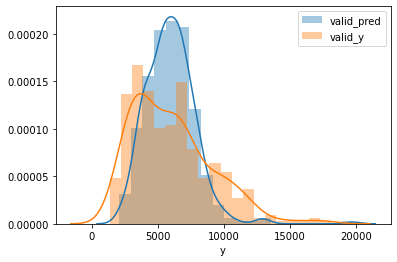

In [15]:
sns.distplot(
    valid_pred,    # データ
    kde = True,      # 近似密度関数の表示有無
    bins = 20,      # 変数の刻み数
    label = 'valid_pred'
) 

sns.distplot(
    valid_y,    # データ
    kde = True,      # 近似密度関数の表示有無
    bins = 20,       # 変数の刻み数
    label = 'valid_y'
) 

plt.legend()
plt.show()

In [16]:
pool = Pool(train_x, label=train_y**0.5, cat_features=cat_cols)
cat_model = cat_model.fit(pool)

Learning rate set to 0.043965
0:	learn: 34.2794902	total: 5.07ms	remaining: 5.07s
1:	learn: 33.2872942	total: 6.88ms	remaining: 3.43s
2:	learn: 32.2762854	total: 7.97ms	remaining: 2.65s
3:	learn: 31.4016586	total: 9.8ms	remaining: 2.44s
4:	learn: 30.5988667	total: 11.4ms	remaining: 2.27s
5:	learn: 29.7810566	total: 13.1ms	remaining: 2.17s
6:	learn: 28.9750680	total: 14.8ms	remaining: 2.1s
7:	learn: 28.2416137	total: 16.4ms	remaining: 2.04s
8:	learn: 27.4872331	total: 18.1ms	remaining: 2s
9:	learn: 26.9220579	total: 19.8ms	remaining: 1.96s
10:	learn: 26.2802378	total: 21.5ms	remaining: 1.93s
11:	learn: 25.6201040	total: 23.1ms	remaining: 1.9s
12:	learn: 25.0033428	total: 24.7ms	remaining: 1.88s
13:	learn: 24.3736140	total: 26.4ms	remaining: 1.86s
14:	learn: 23.8081611	total: 28.1ms	remaining: 1.85s
15:	learn: 23.2808551	total: 29.7ms	remaining: 1.83s
16:	learn: 22.7941470	total: 31.5ms	remaining: 1.82s
17:	learn: 22.3293180	total: 33.2ms	remaining: 1.81s
18:	learn: 21.9289813	total: 34.

In [17]:
pred = cat_model.predict(test_x)**2
pred = np.floor(pred)

In [18]:
# データをcsv形式に加工。
out = pd.DataFrame({'id':test['id'], 'y':pred})

# idでソート。
out_sorted = out.sort_values('id')

out_sorted.to_csv('../submit/yoshioka_catboost_regression.csv', sep=',', header=False, index=False)

In [19]:
out.describe()

,id,y
count,313.000000,313.000000
mean,16142.252396,11679.693291
std,224.441223,7777.181586
min,15822.000000,2311.000000
25%,15907.000000,5958.000000
50%,16261.000000,9620.000000
75%,16346.000000,15288.000000
max,16436.000000,53063.000000


In [20]:
pd.read_csv('../submit/yoshioka_catboost_regression.csv')

,15822,15031.0
0,15823,18232.0
1,15824,30096.0
2,15825,11813.0
3,15827,29329.0
4,15828,15087.0
...,...,...
307,16432,7093.0
308,16433,9865.0
309,16434,7278.0
310,16435,8165.0
